In [9]:
import pandas as pd
import nltk  
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
import re
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
import xgboost as xgb
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
train_data = pd.read_csv('/content/drive/My Drive/train.csv')

In [12]:
with open('/content/drive/My Drive/features.csv', 'rb') as f:
    features=np.load(f)

In [13]:
from sklearn.model_selection import train_test_split

train_data, validation_data,train_features,validation_features= train_test_split(train_data, features,test_size=0.1)

In [14]:
en_stops = set(stopwords.words('english'))
lem=WordNetLemmatizer()
def clean_text(texts):
  clean_texts=[]
  for text in texts : 
    text=re.sub("i'm", "I am ", str(text))
    text=re.sub("'ve", "have", str(text))
    text=re.sub("can't", "cannot", str(text))
    text=re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", str(text))
    text=text.split()
    text=[word for word in text if word not in en_stops]
    text=[word.lower() for word in text]
    text=[lem.lemmatize(word) for word in text]
    clean_texts.append(text)
  return clean_texts

train_q1=clean_text(train_data.question1.values)
train_q2=clean_text(train_data.question2.values)
test_q1=clean_text(validation_data.question1.values)
test_q2=clean_text(validation_data.question2.values)



In [15]:
train_common_words=[]
train_different_words=[]
test_common_words=[]
test_different_words=[]
for i in range(len (train_q1)):
  train_common_words.append([word for word in train_q1[i] if word in train_q2[i] ])
  train_different_words.append([word for word in train_q1[i] if word not in train_q2[i]]+[word for word in train_q2[i] if word not in train_q1[i]] )
for i in range(len (test_q1)):
  test_common_words.append([word for word in test_q1[i] if word in test_q2[i] ])
  test_different_words.append([word for word in test_q1[i] if word not in test_q2[i]]+[word for word in test_q2[i] if word not in test_q1[i]] )

In [16]:
tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(train_q1 + train_q2 + test_q1 + test_q2)
train_questions_1 = tokenizer.texts_to_sequences(train_q1)
train_questions_2 = tokenizer.texts_to_sequences(train_q2)
train_common_words = tokenizer.texts_to_sequences(train_common_words)
train_different_words = tokenizer.texts_to_sequences(train_different_words)
test_questions_1 = tokenizer.texts_to_sequences(test_q1)
test_questions_2 = tokenizer.texts_to_sequences(test_q2)
test_common_words = tokenizer.texts_to_sequences(test_common_words)
test_different_words = tokenizer.texts_to_sequences(test_different_words)

In [17]:
pad_train_q1 = pad_sequences(train_questions_1, maxlen=40)
pad_train_q2 = pad_sequences(train_questions_2, maxlen=40)
pad_train_common_words = pad_sequences(train_common_words, maxlen=40)
pad_train_different_words = pad_sequences(train_different_words, maxlen=40)
pad_train_q2 = pad_sequences(train_questions_2, maxlen=40)
pad_test_q1 = pad_sequences(test_questions_1, maxlen=40)
pad_test_q2 = pad_sequences(test_questions_2, maxlen=40)
pad_test_common_words = pad_sequences(test_common_words, maxlen=40)
pad_test_different_words = pad_sequences(test_different_words, maxlen=40)

In [18]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip
f = open('glove.6B.300d.txt', encoding='utf-8')
embeddings_index = {}
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

--2022-05-01 20:52:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-05-01 20:52:11--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-05-01 20:52:11--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [19]:
embedding_matrix = np.random.random((len(tokenizer.word_index)+1, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [20]:
with open('/content/drive/My Drive/pad_train1.csv', 'wb') as f:
    np.save(f, pad_train_q1)
with open('/content/drive/My Drive/pad_train_2.csv', 'wb') as f:
    np.save(f, pad_train_q2)
with open('/content/drive/My Drive/pad_test_1.csv', 'wb') as f:
    np.save(f, pad_test_q1)
with open('/content/drive/My Drive/pad_test_2.csv', 'wb') as f:
    np.save(f, pad_test_q2)
with open('/content/drive/My Drive/pad_train_common_words.csv', 'wb') as f:
    np.save(f, pad_train_common_words)
with open('/content/drive/My Drive/pad_train_different_words.csv', 'wb') as f:
    np.save(f, pad_train_different_words)
with open('/content/drive/My Drive/pad_test_common_words.csv', 'wb') as f:
    np.save(f, pad_train_common_words)
with open('/content/drive/My Drive/pad_test_different_words.csv', 'wb') as f:
    np.save(f, pad_train_different_words)
with open('/content/drive/My Drive/embedding_matrix.csv', 'wb') as f:
    np.save(f, embedding_matrix)

In [21]:
vocab_size=len(tokenizer.word_index)
print(vocab_size)

133824


In [27]:
import keras.backend as K
#f1 from keras source code
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [36]:
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
input_1 = Input(shape=(None,),dtype='int32')
x1 = Embedding(input_dim = vocab_size+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30,trainable=False)(input_1)
x1 = LSTM(64, activation='tanh',dropout=0.2)(x1)



input_2 = Input(shape=(None,),dtype='int32')
x2 = Embedding(input_dim = vocab_size+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30,trainable=False)(input_2)
x2 = LSTM(64, activation='tanh',dropout=0.2)(x2)



result=concatenate([x1,x2],axis=-1)
result=Flatten()(result)
result=Dense(64,activation='relu')(result)
result=Dropout(0.2)(result)
result=Dense(1,activation='sigmoid')(result)
small_model=Model([input_1, input_2], result)

In [37]:
small_model.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
small_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, None, 300)    40147500    ['input_22[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, None, 300)    40147500    ['input_23[0][0]']               
                                                                                            

In [39]:
small_history_simple=small_model.fit([pad_train_q1, pad_train_q2], train_data.iloc[:,5:].values, 
          validation_data=([pad_test_q1, pad_test_q2], validation_data.iloc[:,5:].values), 
          batch_size=128, epochs=10)

Epoch 1/10
2843/2843 [==============================] - 39s 13ms/step - loss: 0.5250 - accuracy: 0.7317 - f1: 0.5765 - val_loss: 0.4745 - val_accuracy: 0.7646 - val_f1: 0.6576
Epoch 2/10
2843/2843 [==============================] - 30s 10ms/step - loss: 0.4618 - accuracy: 0.7720 - f1: 0.6647 - val_loss: 0.4457 - val_accuracy: 0.7827 - val_f1: 0.7013
Epoch 3/10
2843/2843 [==============================] - 30s 10ms/step - loss: 0.4322 - accuracy: 0.7899 - f1: 0.6993 - val_loss: 0.4321 - val_accuracy: 0.7891 - val_f1: 0.7102
Epoch 4/10
2843/2843 [==============================] - 29s 10ms/step - loss: 0.4122 - accuracy: 0.8017 - f1: 0.7203 - val_loss: 0.4259 - val_accuracy: 0.7941 - val_f1: 0.7231
Epoch 5/10
2843/2843 [==============================] - 30s 10ms/step - loss: 0.3976 - accuracy: 0.8101 - f1: 0.7345 - val_loss: 0.4191 - val_accuracy: 0.7996 - val_f1: 0.7264
Epoch 6/10
2843/2843 [==============================] - 29s 10ms/step - loss: 0.3856 - accuracy: 0.8166 - f1: 0.7452 - v

In [44]:
small_history_simple.history["f1"]

[0.5764544606208801,
 0.6646879315376282,
 0.6992942690849304,
 0.7202714681625366,
 0.734495222568512,
 0.7451789379119873,
 0.7533965110778809,
 0.760974645614624,
 0.7665177583694458,
 0.7727280259132385]

In [45]:
small_model.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
small_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, None, 300)    40147500    ['input_22[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, None, 300)    40147500    ['input_23[0][0]']               
                                                                                            

In [46]:
small_history_intersect=small_model.fit([pad_train_common_words, pad_train_different_words], train_data.iloc[:,5:].values, 
          validation_data=([pad_test_common_words, pad_test_different_words], validation_data.iloc[:,5:].values), 
          batch_size=128, epochs=10)

Epoch 1/10
2843/2843 [==============================] - 36s 12ms/step - loss: 0.4065 - accuracy: 0.8020 - f1: 0.7332 - val_loss: 0.3751 - val_accuracy: 0.8207 - val_f1: 0.7557
Epoch 2/10
2843/2843 [==============================] - 29s 10ms/step - loss: 0.3618 - accuracy: 0.8287 - f1: 0.7672 - val_loss: 0.3640 - val_accuracy: 0.8274 - val_f1: 0.7665
Epoch 3/10
2843/2843 [==============================] - 29s 10ms/step - loss: 0.3432 - accuracy: 0.8391 - f1: 0.7812 - val_loss: 0.3638 - val_accuracy: 0.8300 - val_f1: 0.7769
Epoch 4/10
2843/2843 [==============================] - 29s 10ms/step - loss: 0.3296 - accuracy: 0.8469 - f1: 0.7920 - val_loss: 0.3562 - val_accuracy: 0.8361 - val_f1: 0.7757
Epoch 5/10
2843/2843 [==============================] - 29s 10ms/step - loss: 0.3197 - accuracy: 0.8514 - f1: 0.7982 - val_loss: 0.3542 - val_accuracy: 0.8361 - val_f1: 0.7764
Epoch 6/10
2843/2843 [==============================] - 29s 10ms/step - loss: 0.3108 - accuracy: 0.8566 - f1: 0.8055 - v

In [32]:
#Model with features
input_5 = Input(shape=(10,),dtype='int32')
x5= Dense(128,activation='relu')(input_5)
x5=Dropout(0.2)(x5)
x5= Dense(64,activation='relu')(x5)
result=Dense(1,activation='sigmoid')(x5)
model_features=Model(input_5, result)
model_features.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
model_features.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 10)]              0         
                                                                 
 dense_14 (Dense)            (None, 128)               1408      
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 64)                8256      
                                                                 
 dense_16 (Dense)            (None, 1)                 65        
                                                                 
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [34]:
history_features=model_features.fit(train_features, train_data.iloc[:,5:].values, 
          validation_data=(validation_features, validation_data.iloc[:,5:].values), 
          batch_size=128, epochs=10)

Epoch 1/10
2843/2843 [==============================] - 10s 3ms/step - loss: 0.4993 - accuracy: 0.7189 - f1: 0.6395 - val_loss: 0.4998 - val_accuracy: 0.7226 - val_f1: 0.5947
Epoch 2/10
2843/2843 [==============================] - 10s 4ms/step - loss: 0.4978 - accuracy: 0.7205 - f1: 0.6416 - val_loss: 0.4960 - val_accuracy: 0.7216 - val_f1: 0.6247
Epoch 3/10
2843/2843 [==============================] - 11s 4ms/step - loss: 0.4969 - accuracy: 0.7210 - f1: 0.6437 - val_loss: 0.4932 - val_accuracy: 0.7245 - val_f1: 0.5960
Epoch 4/10
2843/2843 [==============================] - 10s 3ms/step - loss: 0.4960 - accuracy: 0.7206 - f1: 0.6423 - val_loss: 0.4917 - val_accuracy: 0.7281 - val_f1: 0.6250
Epoch 5/10
2843/2843 [==============================] - 11s 4ms/step - loss: 0.4954 - accuracy: 0.7222 - f1: 0.6443 - val_loss: 0.4904 - val_accuracy: 0.7270 - val_f1: 0.6226
Epoch 6/10
2843/2843 [==============================] - 10s 3ms/step - loss: 0.4950 - accuracy: 0.7220 - f1: 0.6446 - val_los

In [49]:
#Final model
input_1 = Input(shape=(None,),dtype='int32')
x1 = Embedding(input_dim = vocab_size+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30,trainable=False)(input_1)
x1 = LSTM(64, activation='tanh',dropout=0.4)(x1)



input_2 = Input(shape=(None,),dtype='int32')
x2 = Embedding(input_dim = vocab_size+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30,trainable=False)(input_2)
x2 = LSTM(64, activation='tanh',dropout=0.4)(x2)

input_3 = Input(shape=(None,),dtype='int32')
x3= Embedding(input_dim = vocab_size+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30,trainable=False)(input_3)
x3 = LSTM(64, activation='tanh',dropout=0.4)(x3)

input_4 = Input(shape=(None,),dtype='int32')
x4= Embedding(input_dim = vocab_size+1,
                       output_dim = 300,
                      weights = [embedding_matrix],
                      input_length = 30,trainable=False)(input_4)
x4 = LSTM(64, activation='tanh',dropout=0.4)(x4)

input_5 = Input(shape=(10,),dtype='int32')
x5= Dense(128,activation='relu')(input_5)
x5=Dropout(0.2)(x5)
x5= Dense(64,activation='relu')(x5)

result=concatenate([x1,x2,x3,x4,x5],axis=-1)
result=Flatten()(result)
result=Dropout(0.2)(result)
result=Dense(128,activation='relu')(result)
result=Dropout(0.2)(result)
result=Dense(1,activation='sigmoid')(result)
final_model=Model([input_1, input_2,input_3,input_4,input_5], result)

In [50]:
final_model.compile(loss='binary_crossentropy', optimizer='adam',metrics = ['accuracy',f1])
final_model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 10)]         0           []                               
                                                                                                  
 input_29 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 input_31 (InputLayer)          [(None, None)]       0           []                               
                                                                                            

In [52]:
final_history=final_model.fit([pad_train_q1,pad_train_q2,pad_train_common_words, pad_train_different_words,train_features], train_data.iloc[:,5:].values, 
          validation_data=([pad_test_q1,pad_test_q2,pad_test_common_words, pad_test_different_words,validation_features], validation_data.iloc[:,5:].values), 
          batch_size=128, epochs=10)

Epoch 1/10
2843/2843 [==============================] - 59s 19ms/step - loss: 0.4543 - accuracy: 0.7724 - f1: 0.6901 - val_loss: 0.3852 - val_accuracy: 0.8133 - val_f1: 0.7490
Epoch 2/10
2843/2843 [==============================] - 54s 19ms/step - loss: 0.3795 - accuracy: 0.8152 - f1: 0.7500 - val_loss: 0.3572 - val_accuracy: 0.8276 - val_f1: 0.7645
Epoch 3/10
2843/2843 [==============================] - 52s 18ms/step - loss: 0.3561 - accuracy: 0.8298 - f1: 0.7704 - val_loss: 0.3419 - val_accuracy: 0.8363 - val_f1: 0.7787
Epoch 4/10
2843/2843 [==============================] - 52s 18ms/step - loss: 0.3403 - accuracy: 0.8387 - f1: 0.7829 - val_loss: 0.3345 - val_accuracy: 0.8401 - val_f1: 0.7821
Epoch 5/10
2843/2843 [==============================] - 52s 18ms/step - loss: 0.3284 - accuracy: 0.8458 - f1: 0.7922 - val_loss: 0.3300 - val_accuracy: 0.8435 - val_f1: 0.7890
Epoch 6/10
2843/2843 [==============================] - 52s 18ms/step - loss: 0.3192 - accuracy: 0.8504 - f1: 0.7982 - v

In [53]:
final_model.save ("model_nlp.h5")

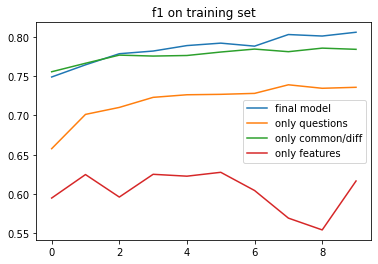

In [60]:
plt.plot(final_history.history["val_f1"])
plt.plot(small_history_simple.history["val_f1"])
plt.plot(small_history_intersect.history["val_f1"])
plt.plot(history_features.history["val_f1"])
plt.title("f1 on training set")
plt.legend(["final model","only questions","only common/diff","only features"])
plt.show()

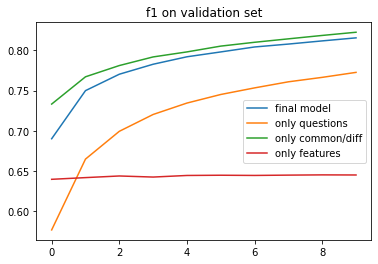

In [61]:
plt.plot(final_history.history["f1"])
plt.plot(small_history_simple.history["f1"])
plt.plot(small_history_intersect.history["f1"])
plt.plot(history_features.history["f1"])
plt.title("f1 on validation set")
plt.legend(["final model","only questions","only common/diff","only features"])
plt.show()

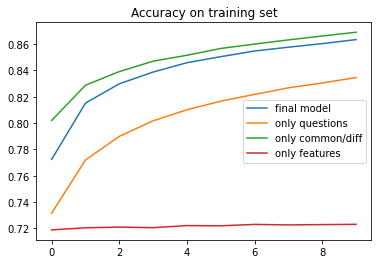

In [62]:
plt.plot(final_history.history["accuracy"])
plt.plot(small_history_simple.history["accuracy"])
plt.plot(small_history_intersect.history["accuracy"])
plt.plot(history_features.history["accuracy"])
plt.title("Accuracy on training set")
plt.legend(["final model","only questions","only common/diff","only features"])
plt.show()

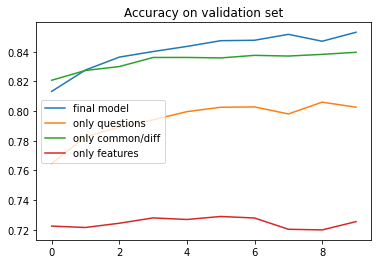

In [63]:
plt.plot(final_history.history["val_accuracy"])
plt.plot(small_history_simple.history["val_accuracy"])
plt.plot(small_history_intersect.history["val_accuracy"])
plt.plot(history_features.history["val_accuracy"])
plt.title("Accuracy on validation set")
plt.legend(["final model","only questions","only common/diff","only features"])
plt.show()

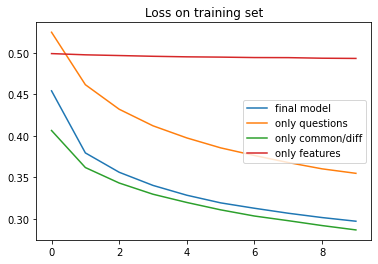

In [65]:
plt.plot(final_history.history["loss"])
plt.plot(small_history_simple.history["loss"])
plt.plot(small_history_intersect.history["loss"])
plt.plot(history_features.history["loss"])
plt.title("Loss on training set")
plt.legend(["final model","only questions","only common/diff","only features"])
plt.show()

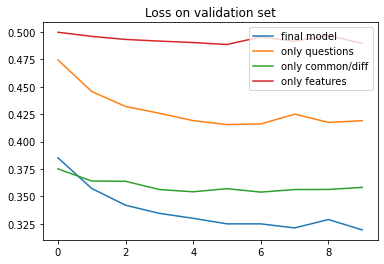

In [64]:
plt.plot(final_history.history["val_loss"])
plt.plot(small_history_simple.history["val_loss"])
plt.plot(small_history_intersect.history["val_loss"])
plt.plot(history_features.history["val_loss"])
plt.title("Loss on validation set")
plt.legend(["final model","only questions","only common/diff","only features"])
plt.show()